<a href="https://colab.research.google.com/github/BomiaoZh/bachelor/blob/main/Bomiao's%20code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,repository,license_count,versionInfo_count,skosConcept_count,owlClass_count,title_count,languages_count,license_score,versionInfo_score,skosConcept_score,owlClass_score,title_score,languages_score,Interoperability_score,Sustainability_score,Multilinguality_score,overall_score
0,LOV,267,2500,5183,53603,3932,111,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000
1,BioPortal,100,50,100,100,0,0,1.0,1.0,1.0,1.0,0.0,0.0,0.666667,1.0,0.0,0.629630
2,OLS,100,50,100,100,100,0,1.0,1.0,1.0,1.0,1.0,0.0,1.000000,1.0,0.0,0.777778
3,BARTOC,100,0,100,100,100,0,1.0,0.0,1.0,1.0,1.0,0.0,1.000000,0.5,0.0,0.611111
4,CLARIAH,100,50,100,100,100,0,1.0,1.0,1.0,1.0,1.0,0.0,1.000000,1.0,0.0,0.777778



 JSON output 
[
  {
    "repository": "LOV",
    "license_count": 267,
    "versionInfo_count": 2500,
    "skosConcept_count": 5183,
    "owlClass_count": 53603,
    "title_count": 3932,
    "languages_count": 111,
    "license_score": 1.0,
    "versionInfo_score": 1.0,
    "skosConcept_score": 1.0,
    "owlClass_score": 1.0,
    "title_score": 1.0,
    "languages_score": 1.0,
    "Interoperability_score": 1.0,
    "Sustainability_score": 1.0,
    "Multilinguality_score": 1.0,
    "overall_score": 1.0
  },
  {
    "repository": "BioPortal",
    "license_count": 100,
    "versionInfo_count": 50,
    "skosConcept_count": 100,
    "owlClass_count": 100,
    "title_count": 0,
    "languages_count": 0,
    "license_score": 1.0,
    "versionInfo_score": 1.0,
    "skosConcept_score": 1.0,
    "owlClass_score": 1.0,
    "title_score": 0.0,
    "languages_score": 0.0,
    "Interoperability_score": 0.6666666666666666,
    "Sustainability_score": 1.0,
    "Multilinguality_score": 0.0,
    "overa

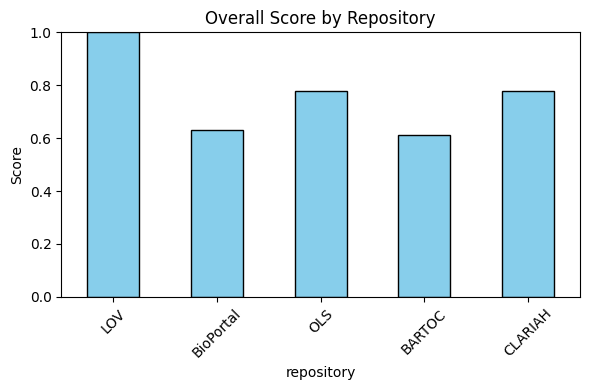

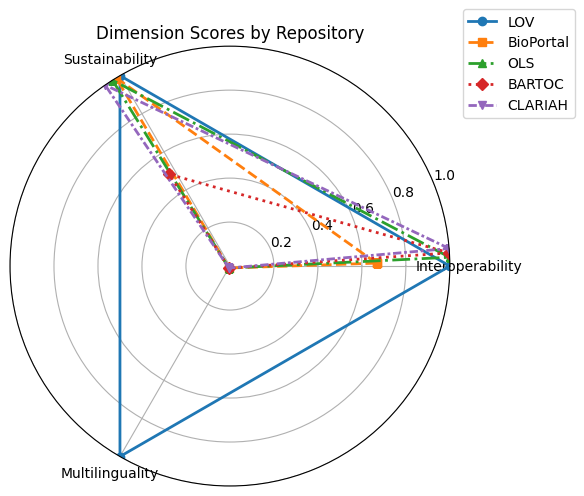

In [3]:
# Using Google Colab to run the following codes.
!pip install SPARQLWrapper pandas matplotlib

import logging
import json
from typing import List, Dict, Any
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from SPARQLWrapper import SPARQLWrapper, JSON

logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

Endpoint = {"LOV": "https://lov.linkeddata.es/dataset/lov/sparql"}

Manually_check = [{"repository": "BioPortal", "license": True, "versionInfo": True, "skosConcept": True, "owlClass": True, "title": False},
    {"repository": "OLS", "license": True, "versionInfo": True, "skosConcept": True, "owlClass": True, "title": True},
    {"repository": "BARTOC", "license": True, "versionInfo": False, "skosConcept": True, "owlClass": True, "title": True},
    {"repository": "CLARIAH", "license": True, "versionInfo": True, "skosConcept": True, "owlClass": True, "title": True}]

Predicate = {"license": "http://purl.org/dc/terms/license",
    "versionInfo": "http://www.w3.org/2002/07/owl#versionInfo",
    "skosConcept": "http://www.w3.org/2004/02/skos/core#Concept",
    "owlClass": "http://www.w3.org/2002/07/owl#Class",
    "title": "http://purl.org/dc/terms/title"}

Threasholds: Dict[str,int] = {"license_count": 100,
    "versionInfo_count": 50,
    "skosConcept_count": 100,
    "owlClass_count": 100,
    "title_count": 100,
    "languages_count": 3}

Criteria = {"Interoperability": ["skosConcept_score", "owlClass_score", "title_score"],
    "Sustainability": ["license_score", "versionInfo_score"],
    "Multilinguality": ["languages_score"]}

COUNT = """
SELECT (COUNT(DISTINCT ?s) AS ?cnt) WHERE {{
    {pattern}
}}
"""
LANGUAGE = """
SELECT DISTINCT (lang(?label) AS ?lang) WHERE {{
  {union_clause}
  FILTER(lang(?label) != "")
}}
"""
LABEL_UNION = """
{{ ?s <http://www.w3.org/2000/01/rdf-schema#label> ?label . }}
UNION
{{ ?s <http://www.w3.org/2004/02/skos/core#prefLabel> ?label . }}
"""

def count_triples(endpoint: str, key: str) -> int:
    sparql = SPARQLWrapper(endpoint)
    sparql.setReturnFormat(JSON)
    pattern = (
        f"?s a <{Predicate[key]}> ."
        if key in ("skosConcept", "owlClass")
        else f"?s <{Predicate[key]}> ?o ."
    )
    sparql.setQuery(COUNT.format(pattern=pattern))
    try:
        res = sparql.query().convert()
        return int(res["results"]["bindings"][0]["cnt"]["value"])
    except Exception as e:
        logging.warning(f"{key}@{endpoint} -> 0 ({e.__class__.__name__})")
        return 0

def count_languages(endpoint: str) -> int:
    sparql = SPARQLWrapper(endpoint)
    sparql.setReturnFormat(JSON)
    sparql.setQuery(LANGUAGE.format(union_clause=LABEL_UNION))
    try:
        res = sparql.query().convert()
        langs = {b["lang"]["value"] for b in res["results"]["bindings"]}
        return len(langs)
    except Exception as e:
        logging.warning(f"languages@{endpoint} -> 0 ({e.__class__.__name__})")
        return 0

# evaluation matrix
def evaluate_endpoint(endpoint: str, name: str) -> Dict[str,Any]:
    entry = {"repository": name}
    for key in Predicate:
        entry[f"{key}_count"] = count_triples(endpoint, key)
    entry["languages_count"] = count_languages(endpoint)
    return entry

def build_manual_data() -> List[Dict[str,Any]]:
    rows: List[Dict[str,Any]] = []
    for m in Manually_check:
        row = {"repository": m["repository"]}
        for key in Predicate:
            row[f"{key}_count"] = Threasholds[f"{key}_count"] if m[key] else 0
        row["languages_count"] = 0
        rows.append(row)
    return rows

# execute evaluations
evaluated = [evaluate_endpoint(url, name) for name, url in Endpoint.items()]
evaluated.extend(build_manual_data())

dataframe = pd.DataFrame(evaluated)

# count criteria's scores
for cnt_col, thresh in Threasholds.items():
    score_col = cnt_col.replace("_count", "_score")
    dataframe[score_col] = (dataframe[cnt_col] / thresh).clip(0,1)

for dim, cols in Criteria.items():
    dataframe[f"{dim}_score"] = dataframe[cols].mean(axis=1)

# total score
ScoreCol = [c for c in dataframe.columns if c.endswith("_score")]
dataframe["overall_score"] = dataframe[ScoreCol].mean(axis=1)

from IPython.display import display
display(dataframe)

# Print JSON equivalent to /evaluate_all
print("\n JSON output ")
print(json.dumps(dataframe.to_dict(orient="records"), ensure_ascii=False, indent=2))

# Bar chart of overall scores
plt.figure(figsize=(6,4))
dataframe.set_index("repository")["overall_score"].plot.bar(color="skyblue", edgecolor="k")
plt.title("Overall Score by Repository")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Radar chart of dimensional scores
lbls = list(Criteria.keys())
agls = np.linspace(0, 2*np.pi, len(lbls), endpoint=False).tolist()
agls += agls[:1]

c = {"LOV": "#1f77b4", "BioPortal": "#ff7f0e", "OLS": "#2ca02c", "BARTOC": "#d62728", "CLARIAH": "#9467bd"}
mkrs = {"LOV":"o","BioPortal":"s","OLS":"^","BARTOC":"D","CLARIAH":"v"}
lineStl = {"LOV":"-","BioPortal":"--","OLS":"-.","BARTOC":":","CLARIAH":(0,(3,1,1,1))}

plt.figure(figsize=(6,6))
for idx, row in dataframe.iterrows():
    repository = row["repository"]
    values = [row[f"{dim}_score"] for dim in lbls]
    if values[-1] == 0:
        values[-1] = 0.01
    values += [values[0]]
    shift = idx * 0.02
    shifted_angles = [a + shift for a in agls]
    plt.polar(shifted_angles, values, color=c[repository], marker=mkrs[repository], linestyle=lineStl[repository], linewidth=2, label=repository)

plt.thetagrids(np.degrees(agls[:-1]), lbls)
plt.title("Dimension Scores by Repository")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.ylim(0,1)
plt.tight_layout()
plt.show()